In [2]:
import numpy as np
from SALib.sample import saltelli
from SALib.analyze import sobol
import matplotlib.pyplot 

##########################
#http0.1://salib.readthedocs.io/en/latest/basics_with_interface.html
##########################



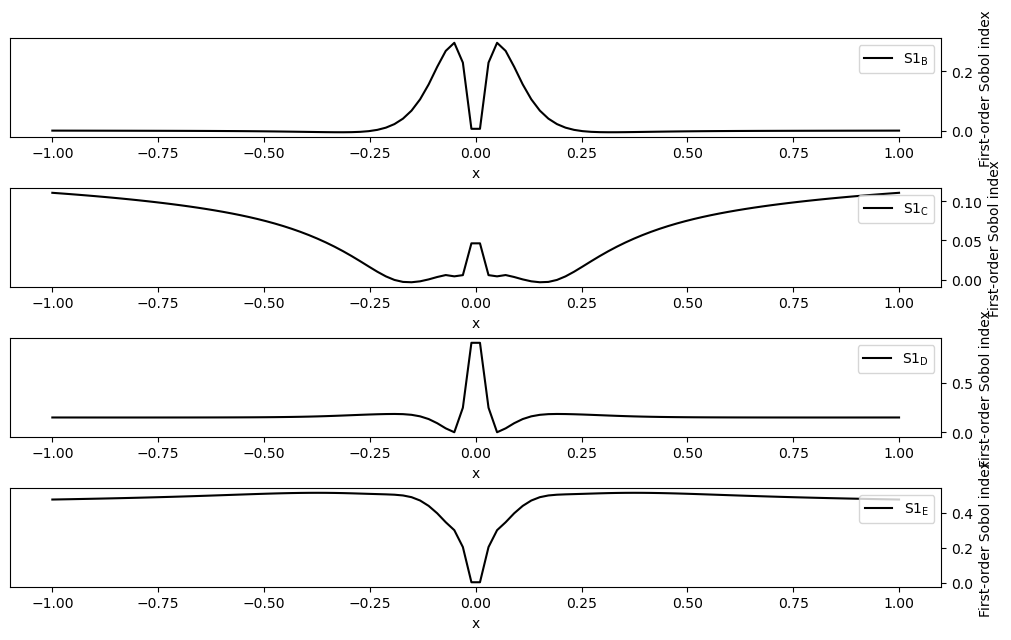

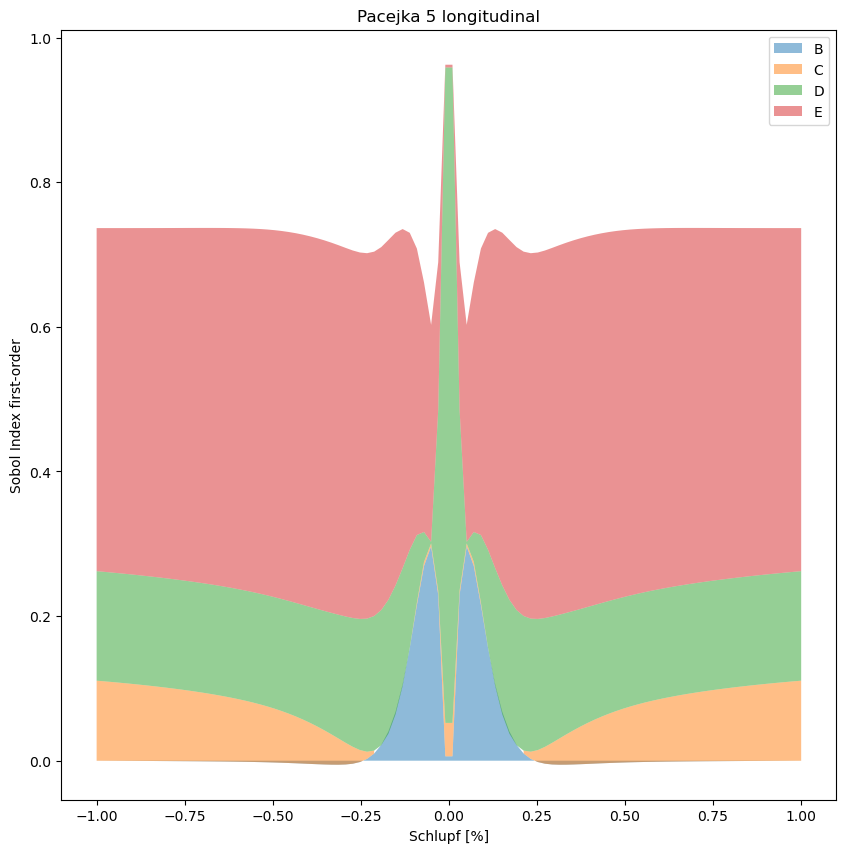

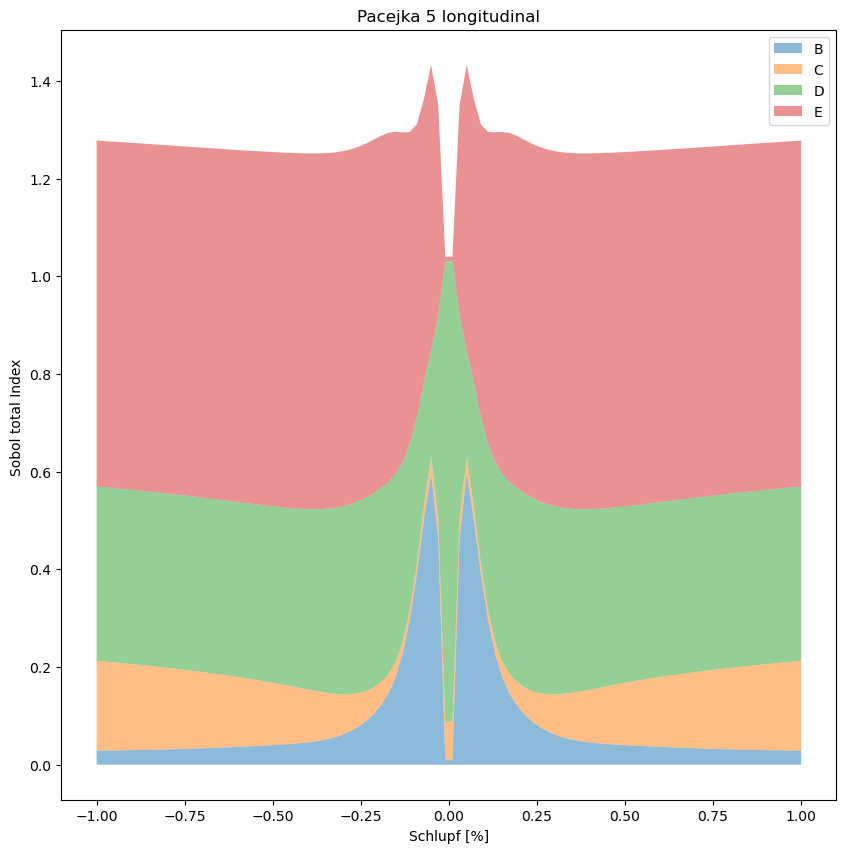

[0.02693984 0.0628634  0.1689173  0.46996136]
[0.09278719 0.11588675 0.37239476 0.68858661]


In [3]:
#same SA for Pacejka5 longitudenal

import numpy as np
import matplotlib.pyplot as plt
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib import ProblemSpec

import sys
import os
sys.path.insert(0, os.path.abspath('../model'))
import Pacejka52 as pa52
Fz = 4000
#function
def Pacejka5_long_fit(SL,B,C,D,E):

    Fx=Fz* D * np.sin(C * np.arctan(D * SL - E * (B*SL - np.arctan(B * SL)))) 
    
    return Fx
params_SA_Fx = [-9.06434405,  1.60162373, -1.72069169, -0.80265574]
s=0.2
sp = ProblemSpec( {
    'num_vars': 4,
    'names': ['B', 'C', 'D', 'E'],
    #'bounds': [[-9.06434405*(1+s),-9.06434405*(1-s)], [1.60162373*(1-s), 1.60162373*(1+s)], [-1.72069169*(1+s), -1.72069169*(1-s)], [-0.80265574 * (1+s), -0.80265574*(1-s)]],
    'bounds': [[-12,-4], [1, 2], [0.1,1.9], [-10, 1]],
})

SL = np.linspace(-1,1,100)

# Create wrapper (runs each a, b combination separately)
def wrapped_function(ab, SL=SL):
    y = np.zeros((ab.shape[0], SL.shape[0]))
    for i, (B,C,D,E) in enumerate(ab):
        y[i,:] = Pacejka5_long_fit(SL,B,C,D,E)

    return y

(
sp.sample_sobol(2**10)
.evaluate(wrapped_function)
.analyze_sobol()
)

S1s = np.array([sp.analysis[_y]['S1'] for _y in sp['outputs']])
STs = np.array([sp.analysis[_y]['ST'] for _y in sp['outputs']])
y = sp.results

#Plot: Sensitivity Index für jeden Wert von SL
# Set up figure
fig = plt.figure(figsize=(10, 6), constrained_layout=True)
gs = fig.add_gridspec(4, 1)

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[2, 0])
ax3 = fig.add_subplot(gs[3, 0])
# Populate figure subplots
for i, ax in enumerate([ax0, ax1, ax2, ax3]):
    ax.plot(SL, S1s[:, i],
            label=r'S1$_\mathregular{{{}}}$'.format(sp["names"][i]),
            color='black')
    ax.set_xlabel("x")
    ax.set_ylabel("First-order Sobol index")

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    
    ax.legend(loc='upper right')
    
#alle zusammen plotten

S1s_B  = np.array(S1s[:,0])
S1s_C  = np.array(S1s[:,1])
S1s_D  = np.array(S1s[:,2])
S1s_E  = np.array(S1s[:,3])

S1s_C_plt = np.array([x+y for x,y in zip(S1s_B,S1s_C)])
S1s_D_plt = np.array([x+y for x,y in zip(S1s_C_plt,S1s_D)])
S1s_E_plt = np.array([x+y for x,y in zip(S1s_D_plt,S1s_E)])

plt.figure(2, figsize=(10,10))
plt.fill_between(SL,S1s_B,0, alpha=0.5, label = 'B') #alpha = deckkraft farbe
plt.fill_between(SL,S1s_B,S1s_C_plt, where = (S1s_C_plt > S1s_B), alpha=0.5, label = 'C')
plt.fill_between(SL,S1s_C_plt,S1s_D_plt, where = (S1s_D_plt > S1s_C_plt), alpha=0.5, label = 'D')
plt.fill_between(SL,S1s_D_plt,S1s_E_plt, where = (S1s_E_plt > S1s_D_plt), alpha=0.5, label = 'E')
plt.xlabel('Schlupf [%]')
plt.ylabel('Sobol Index first-order')
plt.title('Pacejka 5 longitudinal')
plt.legend(loc='upper right')
plt.show()


STs_B  = np.array(STs[:,0])
STs_C  = np.array(STs[:,1])
STs_D  = np.array(STs[:,2])
STs_E  = np.array(STs[:,3])

STs_C_plt = np.array([x+y for x,y in zip(STs_B,STs_C)])
STs_D_plt = np.array([x+y for x,y in zip(STs_C_plt,STs_D)])
STs_E_plt = np.array([x+y for x,y in zip(STs_D_plt,STs_E)])

plt.figure(3, figsize=(10,10))
plt.fill_between(SL,STs_B,0, alpha=0.5, label = 'B') #alpha = deckkraft farbe
plt.fill_between(SL,STs_B,STs_C_plt, where = (STs_C_plt > STs_B), alpha=0.5, label = 'C')
plt.fill_between(SL,STs_C_plt,STs_D_plt, where = (STs_D_plt > STs_C_plt), alpha=0.5, label = 'D')
plt.fill_between(SL,STs_D_plt,STs_E_plt, where = (STs_E_plt > STs_D_plt), alpha=0.5, label = 'E')
plt.xlabel('Schlupf [%]')
plt.ylabel('Sobol total Index ')
plt.title('Pacejka 5 longitudinal')
plt.legend(loc='upper right')
plt.show()


#Mean of Sensitvity indexes of first order index
# for ranking parameters on influence on the model output (direkter Einfluss auf die Ausgangsgröße)

S1_mean = np.zeros(4)
i=0
for i in range(0,4):
    S1_mean[i] = np.mean(S1s[:,i])


#Mean of Sensitvity indexes of total index
# includes first and all higher order index (berücksichtig Wechselwirkungseffekte zwischen den Parametern, wichtig für nicht-lineare Modelle)
ST_mean = np.zeros(4)
i=0
for i in range(0,4):
    ST_mean[i] = np.mean(STs[:,i])

print(S1_mean)
print(ST_mean)


In [1]:
SL = np.linspace(0,1,100)
F = Pacejka5_long_fit(SL,-40,2,0.1,1)

plt.plot(SL,F)

NameError: name 'np' is not defined

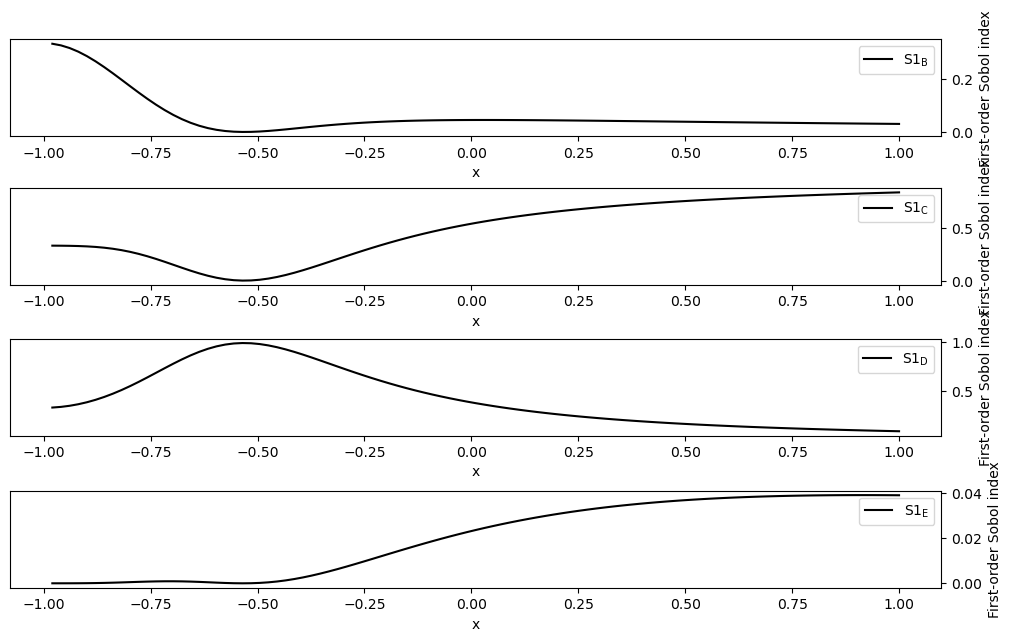

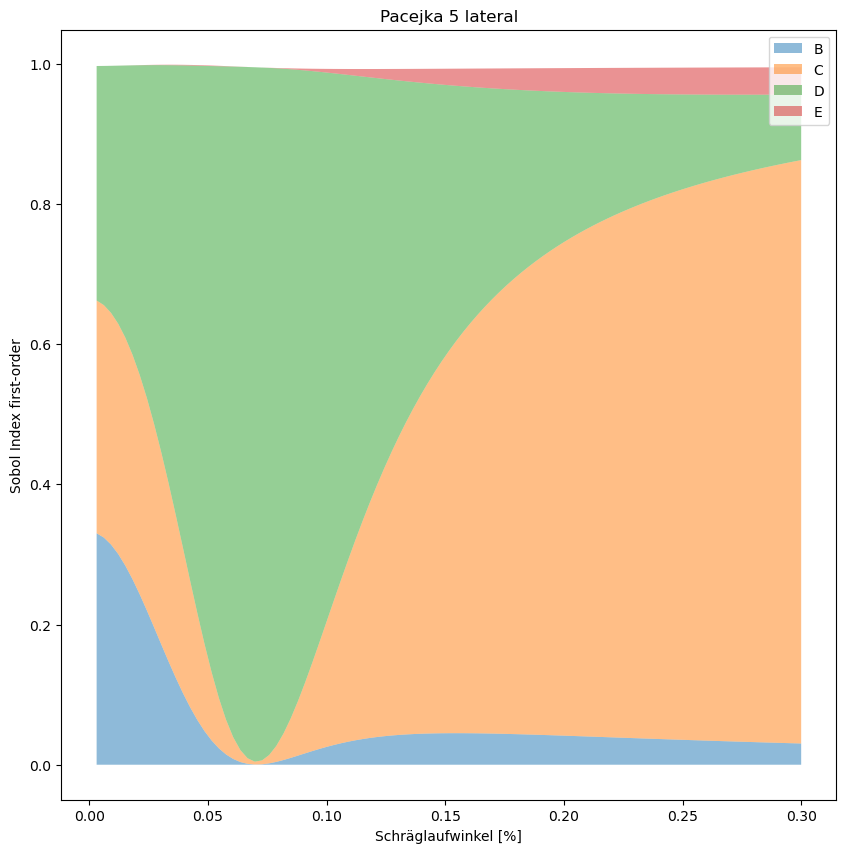

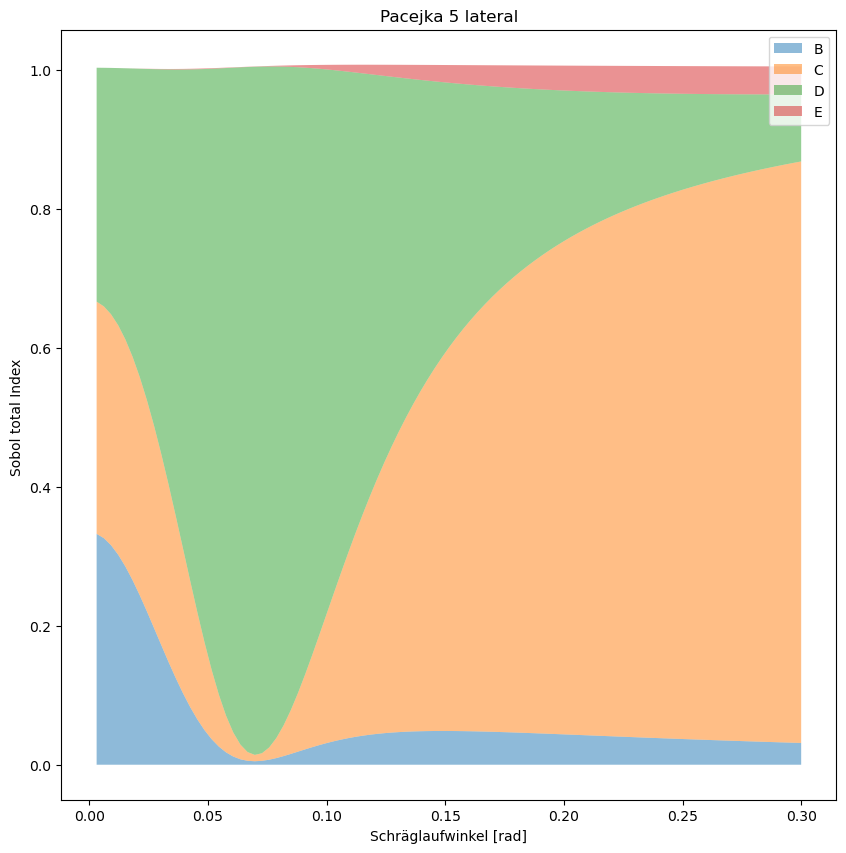

In [21]:
#same SA for Pacejka5 lateral

import numpy as np
import matplotlib.pyplot as plt
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib import ProblemSpec

#function
def Pacejka5_lat(alpha,B,C,D,E):

    Fy= 4000 *D * np.sin(C * np.arctan(B * alpha - E * (B*alpha - np.arctan(B * alpha)))) 
    
    return Fy
params_SA_Fy = [-9.06434405 , 1.60162373, -1.72069169, -0.80265574]
s=0.1
sp = ProblemSpec({
    'num_vars': 4,
    'names': ['B', 'C', 'D', 'E'],
    'bounds': [[17.04378049 *(1-s),17.04378049*(1+s)], [1.99996234*(1-s), 1.99996234*(1+s)], [1.82504605*(1-s), 1.82504605*(1+s)], [0.62177794*(1-s), 0.62177794*(1+s)]],
})

alpha = np.linspace(0,0.3,100)

# Create wrapper (runs each a, b combination separately)
def wrapped_function(ab, alpha=alpha):
    y = np.zeros((ab.shape[0], alpha.shape[0]))
    for i, (B,C,D,E) in enumerate(ab):
        y[i,:] = Pacejka5_lat(alpha,B,C,D,E)

    return y

(
sp.sample_sobol(2**14) #16000 iterationen
.evaluate(wrapped_function)
.analyze_sobol()
)

S1s = np.array([sp.analysis[_y]['S1'] for _y in sp['outputs']])

STs = np.array([sp.analysis[_y]['ST'] for _y in sp['outputs']])
y = sp.results

#Plot: Sensitivity Index für jeden Wert von SL
# Set up figure
fig = plt.figure(figsize=(10, 6), constrained_layout=True)
gs = fig.add_gridspec(4, 1)

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[2, 0])
ax3 = fig.add_subplot(gs[3, 0])
# Populate figure subplots
for i, ax in enumerate([ax0, ax1, ax2, ax3]):
    ax.plot(SL, S1s[:, i],
            label=r'S1$_\mathregular{{{}}}$'.format(sp["names"][i]),
            color='black')
    ax.set_xlabel("x")
    ax.set_ylabel("First-order Sobol index")

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    
    ax.legend(loc='upper right')

#alle zusammen plotten

S1s_B  = np.array(S1s[:,0])
S1s_C  = np.array(S1s[:,1])
S1s_D  = np.array(S1s[:,2])
S1s_E  = np.array(S1s[:,3])

S1s_C_plt = np.array([x+y for x,y in zip(S1s_B,S1s_C)])
S1s_D_plt = np.array([x+y for x,y in zip(S1s_C_plt,S1s_D)])
S1s_E_plt = np.array([x+y for x,y in zip(S1s_D_plt,S1s_E)])

plt.figure(2, figsize=(10,10))
plt.fill_between(alpha,S1s_B,0, alpha=0.5, label = 'B') #alpha = deckkraft farbe
plt.fill_between(alpha,S1s_B,S1s_C_plt, where = (S1s_C_plt > S1s_B), alpha=0.5, label = 'C')
plt.fill_between(alpha,S1s_C_plt,S1s_D_plt, where = (S1s_D_plt > S1s_C_plt), alpha=0.5, label = 'D')
plt.fill_between(alpha,S1s_D_plt,S1s_E_plt, where = (S1s_E_plt > S1s_D_plt), alpha=0.5, label = 'E')
plt.xlabel('Schräglaufwinkel [%]')
plt.ylabel('Sobol Index first-order')
plt.title('Pacejka 5 lateral')
plt.legend(loc='upper right')
plt.show()

STs_B  = np.array(STs[:,0])
STs_C  = np.array(STs[:,1])
STs_D  = np.array(STs[:,2])
STs_E  = np.array(STs[:,3])

STs_C_plt = np.array([x+y for x,y in zip(STs_B,STs_C)])
STs_D_plt = np.array([x+y for x,y in zip(STs_C_plt,STs_D)])
STs_E_plt = np.array([x+y for x,y in zip(STs_D_plt,STs_E)])

plt.figure(3, figsize=(10,10))
plt.fill_between(alpha,STs_B,0, alpha=0.5, label = 'B') #alpha = deckkraft farbe
plt.fill_between(alpha,STs_B,STs_C_plt, where = (STs_C_plt > STs_B), alpha=0.5, label = 'C')
plt.fill_between(alpha,STs_C_plt,STs_D_plt, where = (STs_D_plt > STs_C_plt), alpha=0.5, label = 'D')
plt.fill_between(alpha,STs_D_plt,STs_E_plt, where = (STs_E_plt > STs_D_plt), alpha=0.5, label = 'E')
plt.xlabel('Schräglaufwinkel [rad]')
plt.ylabel('Sobol total Index ')
plt.title('Pacejka 5 lateral')
plt.legend(loc='upper right')
plt.show()




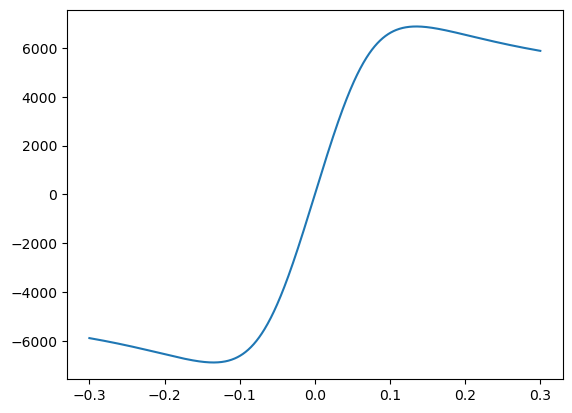

In [19]:
def Pacejka5_lat_pa(alpha,B,C,D,E):

    Fy= 4000 *D * np.sin(C * np.arctan(B * alpha - E * (B*alpha - np.arctan(B * alpha)))) 
    
    return Fy
params_SA_Fy = [-9.06434405 , 1.60162373, -1.72069169, -0.80265574]

Slip = np.linspace(-0.3,0.3,1000)
Fy_spax = Pacejka5_lat_pa(Slip,*params_SA_Fy)
plt.plot(Slip,Fy_spax)

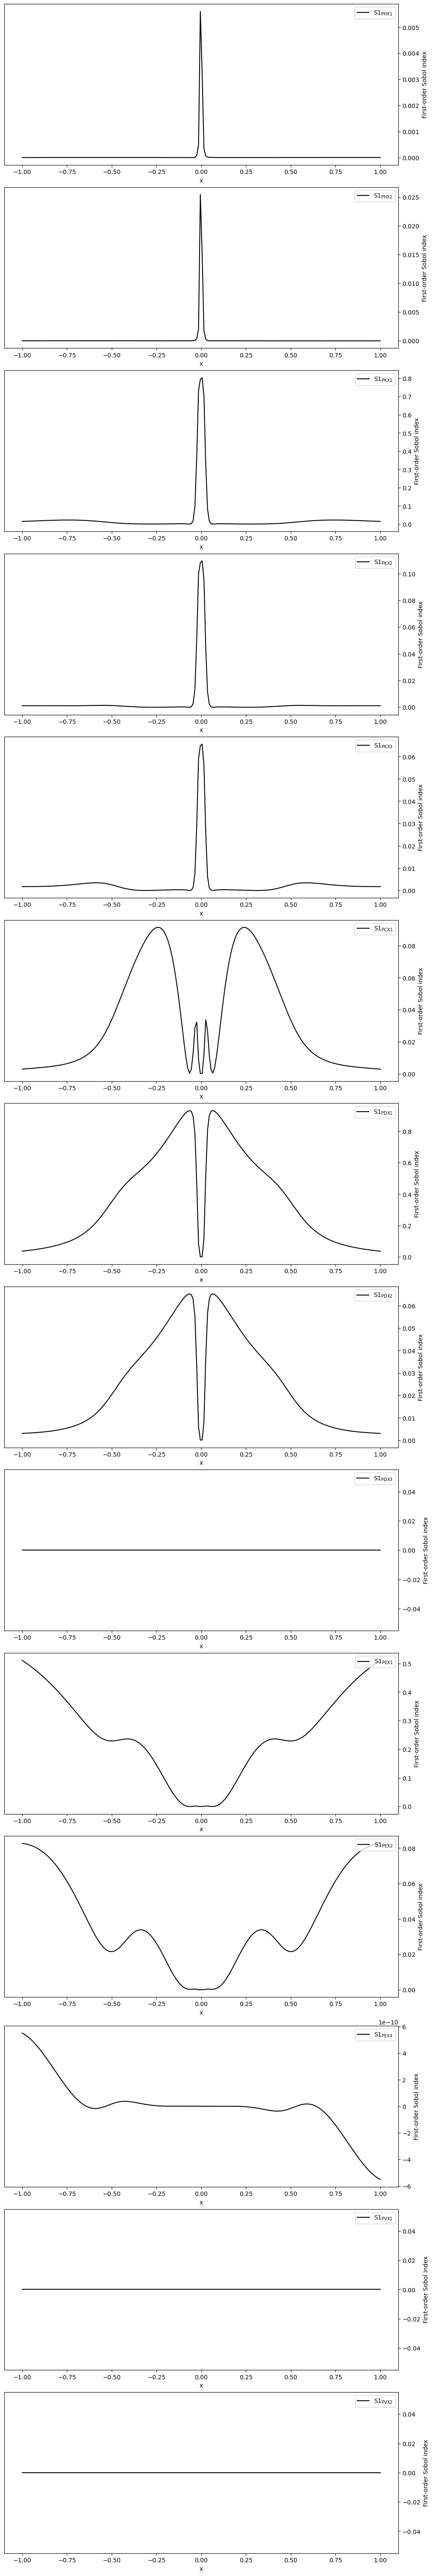

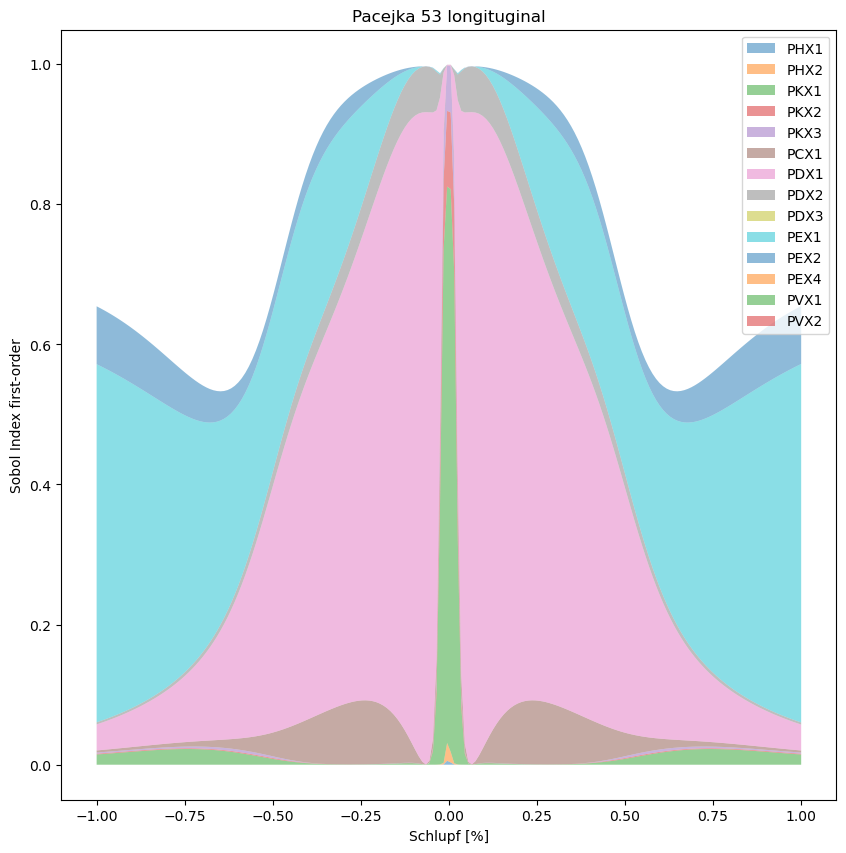

[ 4.93398113e-05  2.25685111e-04  2.97840100e-02  3.41814525e-03
  2.97085188e-03  3.33144837e-02  3.74242925e-01  2.48795590e-02
  0.00000000e+00  2.47891433e-01  3.78633115e-02 -3.47829868e-13
  0.00000000e+00  0.00000000e+00]
[4.98652013e-05 2.27867166e-04 5.90386324e-02 8.28130636e-03
 5.14559450e-03 8.10894708e-02 3.89570151e-01 2.72152268e-02
 0.00000000e+00 4.82542007e-01 2.30936227e-01 3.22488285e-16
 0.00000000e+00 0.00000000e+00]


In [8]:
##################################
#Pacejka 52 Params global SA
##################################

import sys
import os
sys.path.insert(0, os.path.abspath('../model'))
import Pacejka52_gl52 as pa52

import sys
import os
sys.path.insert(0, os.path.abspath('../parameter'))
import Pacejka_Params_Indy as pa

s = 0.1

sp = ProblemSpec({
    'num_vars': 14,
    'names': ['PHX1', 'PHX2', 'PKX1', 'PKX2', 'PKX3', 'PCX1', 'PDX1', 'PDX2', 'PDX3', 'PEX1', 'PEX2', 'PEX4', 'PVX1', 'PVX2'],
    'bounds': [
    [-0.000638, -0.000522],
    [0.000711, 0.000869], 
    [57.375, 70.125], 
    [-16.5, -13.5],
    [0.2891 * 0.9, 0.2891 * 1.1],
    [2 * 0.9, 2 * 1.1],
    [1.7168 * 0.9, 1.7168 * 1.1],
    [-0.3179, -0.2601],
    [-1e-9, 1e-9],
    [0.6975 * 0.9, 0.6975 * 1.1],
    [0.20123 * 0.9, 0.20123 * 1.1],
    [-1e-9, 1e-9],
    [-1e-9, 1e-9],
    [-1e-9, 1e-9]
    ]
})

SL = np.linspace(-1,1,200)

# Create wrapper (runs each a, b combination separately)
i=0
def wrapped_function(ab, SL=SL):
    y = np.zeros((ab.shape[0], SL.shape[0]))
    for i, (PHX1, PHX2, PKX1, PKX2, PKX3, PCX1, PDX1, PDX2, PDX3, PEX1, PEX2, PEX4, PVX1, PVX2) in enumerate(ab):
        y[i,:] = pa52.Pacejka52_long(SL,PHX1, PHX2, PKX1, PKX2, PKX3, PCX1, PDX1, PDX2, PDX3, PEX1, PEX2, PEX4, PVX1, PVX2)[0]

    return y

(
sp.sample_sobol(2**12)
.evaluate(wrapped_function)
.analyze_sobol()
)


S1s = np.array([sp.analysis[_y]['S1'] for _y in sp['outputs']])
STs = np.array([sp.analysis[_y]['ST'] for _y in sp['outputs']])
y = sp.results

#Plot: Sensitivity Index für jeden Wert von SL
# Set up figure
fig = plt.figure(figsize=(10, 60), constrained_layout=True)
gs = fig.add_gridspec(14, 1)

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[2, 0])
ax3 = fig.add_subplot(gs[3, 0])
ax4 = fig.add_subplot(gs[4, 0])
ax5 = fig.add_subplot(gs[5, 0])
ax6 = fig.add_subplot(gs[6, 0])
ax7 = fig.add_subplot(gs[7, 0])
ax8 = fig.add_subplot(gs[8, 0])
ax9 = fig.add_subplot(gs[9, 0])
ax10 = fig.add_subplot(gs[10, 0])
ax11 = fig.add_subplot(gs[11, 0])
ax12 = fig.add_subplot(gs[12, 0])
ax13 = fig.add_subplot(gs[13, 0])


# Populate figure subplots
for i, ax in enumerate([ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13]):
    ax.plot(SL, S1s[:, i],
            label=r'S1$_\mathregular{{{}}}$'.format(sp["names"][i]),
            color='black')
    ax.set_xlabel("x")
    ax.set_ylabel("First-order Sobol index")

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    
    ax.legend(loc='upper right')

#Mean of Sensitvity indexes of first order index
# for ranking parameters on influence on the model output (direkter Einfluss auf die Ausgangsgröße)

S1_mean = np.zeros(14)
i=0
for i in range(0,14):
    S1_mean[i] = np.mean(S1s[:,i])

#alle zusammen plotten
#PHX1, PHX2, PKX1, PKX2, PKX3, PCX1, PDX1, PDX2, PDX3, PEX1, PEX2, PEX4, PVX1, PVX2

S1s_PHX1  = np.array(S1s[:,0])
S1s_PHX2  = np.array(S1s[:,1])
S1s_PKX1  = np.array(S1s[:,2])
S1s_PKX2  = np.array(S1s[:,3])
S1s_PKX3 = np.array(S1s[:,4])
S1s_PCX1  = np.array(S1s[:,5])
S1s_PDX1 = np.array(S1s[:,6])
S1s_PDX2 = np.array(S1s[:,7])
S1s_PDX3 = np.array(S1s[:,8])
S1s_PEX1  = np.array(S1s[:,9])
S1s_PEX2 = np.array(S1s[:,10])
S1s_PEX4 = np.array(S1s[:,11])
S1s_PVX1 = np.array(S1s[:,12])
S1s_PVX2 = np.array(S1s[:,13])

S1s_PHX2_plt = np.array([x+y for x,y in zip(S1s_PHX1,S1s_PHX2)])
S1s_PKX1_plt = np.array([x+y for x,y in zip(S1s_PHX2_plt,S1s_PKX1)])
S1s_PKX2_plt = np.array([x+y for x,y in zip(S1s_PKX1_plt,S1s_PKX2)])
S1s_PKX3_plt = np.array([x+y for x,y in zip(S1s_PKX2_plt,S1s_PKX3)])
S1s_PCX1_plt = np.array([x+y for x,y in zip(S1s_PKX3_plt,S1s_PCX1)])
S1s_PDX1_plt = np.array([x+y for x,y in zip(S1s_PCX1_plt,S1s_PDX1)])
S1s_PDX2_plt = np.array([x+y for x,y in zip(S1s_PDX1_plt,S1s_PDX2)])
S1s_PDX3_plt = np.array([x+y for x,y in zip(S1s_PDX2_plt,S1s_PDX3)])
S1s_PEX1_plt = np.array([x+y for x,y in zip(S1s_PDX3_plt,S1s_PEX1)])
S1s_PEX2_plt = np.array([x+y for x,y in zip(S1s_PEX1_plt,S1s_PEX2)])
S1s_PEX4_plt = np.array([x+y for x,y in zip(S1s_PEX2_plt,S1s_PEX4)])
S1s_PVX1_plt = np.array([x+y for x,y in zip(S1s_PEX4_plt,S1s_PVX1)])
S1s_PVX2_plt = np.array([x+y for x,y in zip(S1s_PVX1_plt,S1s_PVX2)])


plt.figure(2, figsize=(10,10))
plt.fill_between(SL,S1s_PHX1,0, alpha=0.5, label = 'PHX1') #alpha = deckkraft farbe
plt.fill_between(SL,S1s_PHX1,S1s_PHX2_plt, where = (S1s_PHX2_plt > S1s_PHX1), alpha=0.5, label = 'PHX2')
plt.fill_between(SL,S1s_PHX2_plt,S1s_PKX1_plt, where = (S1s_PKX1_plt > S1s_PHX2_plt), alpha=0.5, label = 'PKX1')
plt.fill_between(SL,S1s_PKX1_plt,S1s_PKX2_plt, where = (S1s_PKX2_plt > S1s_PKX1_plt), alpha=0.5, label = 'PKX2')
plt.fill_between(SL,S1s_PKX2_plt,S1s_PKX3_plt, where = (S1s_PKX3_plt > S1s_PKX2_plt), alpha=0.5, label = 'PKX3')
plt.fill_between(SL,S1s_PKX3_plt,S1s_PCX1_plt, where = (S1s_PCX1_plt > S1s_PKX3_plt), alpha=0.5, label = 'PCX1')
plt.fill_between(SL,S1s_PCX1_plt,S1s_PDX1_plt, where = (S1s_PDX1_plt > S1s_PCX1_plt), alpha=0.5, label = 'PDX1')
plt.fill_between(SL,S1s_PDX1_plt,S1s_PDX2_plt, where = (S1s_PDX2_plt > S1s_PDX1_plt), alpha=0.5, label = 'PDX2')
plt.fill_between(SL,S1s_PDX2_plt,S1s_PDX3_plt, where = (S1s_PDX3_plt > S1s_PDX2_plt), alpha=0.5, label = 'PDX3')
plt.fill_between(SL,S1s_PDX3_plt,S1s_PEX1_plt, where = (S1s_PEX1_plt > S1s_PDX3_plt), alpha=0.5, label = 'PEX1')
plt.fill_between(SL,S1s_PEX1_plt,S1s_PEX2_plt, where = (S1s_PEX2_plt > S1s_PEX1_plt), alpha=0.5, label = 'PEX2')
plt.fill_between(SL,S1s_PEX2_plt,S1s_PEX4_plt, where = (S1s_PEX4_plt > S1s_PEX2_plt), alpha=0.5, label = 'PEX4')
plt.fill_between(SL,S1s_PEX4_plt,S1s_PVX1_plt, where = (S1s_PVX1_plt > S1s_PEX4_plt), alpha=0.5, label = 'PVX1')
plt.fill_between(SL,S1s_PVX1_plt,S1s_PVX2_plt, where = (S1s_PVX2_plt > S1s_PVX1_plt), alpha=0.5, label = 'PVX2')

plt.xlabel('Schlupf [%]')
plt.ylabel('Sobol Index first-order')
plt.title('Pacejka 53 longituginal')
plt.legend(loc='upper right')
plt.show()



#Mean of Sensitvity indexes of total index
# includes first and all higher order index (berücksichtig Wechselwirkungseffekte zwischen den Parametern, wichtig für nicht-lineare Modelle)
ST_mean = np.zeros(14)
i=0
for i in range(0,14):
    ST_mean[i] = np.mean(STs[:,i])

print(S1_mean)
print(ST_mean)

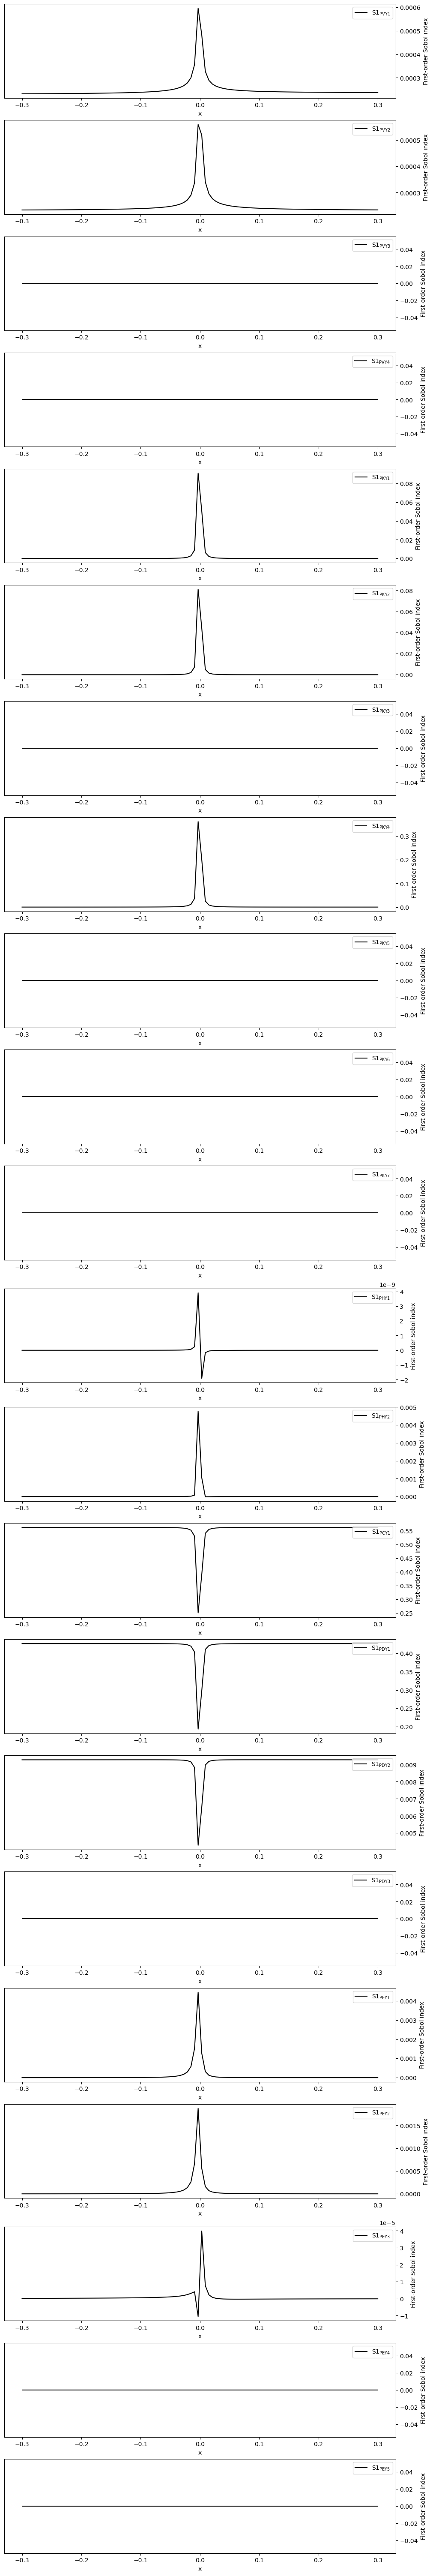

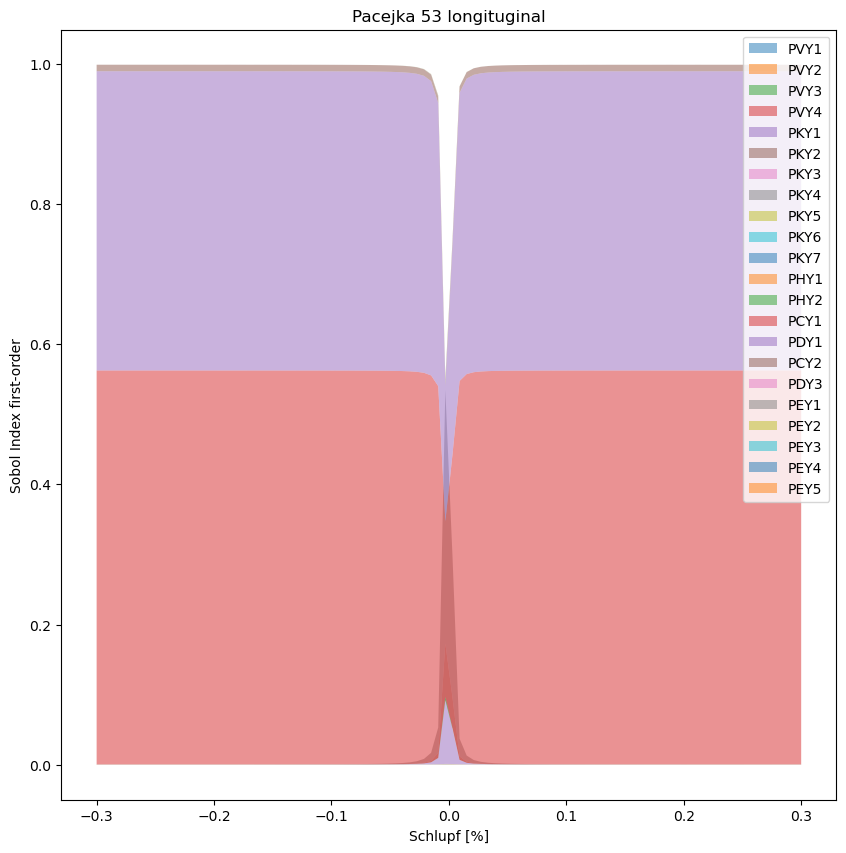

In [1]:
##################################
#Pacejka 52 Params global SA lateral
##################################

import numpy as np
import matplotlib.pyplot as plt
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib import ProblemSpec

import sys
import os
sys.path.insert(0, os.path.abspath('../model'))
import Pacejka52_glSA as pa52

import sys
import os
sys.path.insert(0, os.path.abspath('../model/parameter'))
import Pacejka_Params_Indy as pa

s = 0.1

sp = ProblemSpec({
    'num_vars': 22,
    'names': ['PVY1', 'PVY2', 'PVY3', 'PVY4', 'PKY1', 'PKY2', 'PKY3', 'PKY4', 'PKY5', 'PKY6', 'PKY7', 'PHY1', 'PHY2', 'PCY1', 'PDY1', 'PDY2', 'PDY3', 'PEY1', 'PEY2', 'PEY3', 'PEY4', 'PEY5'],
    'bounds': [
    [-0.01038 * (1 + s), -0.01038 * (1 - s)],
    [-0.1* (1 + s), -0.1* (1 - s)], 
    [0.4498* (1 - s), 0.4498* (1 + s)], 
    [-1.5* (1 + s), -1.5* (1 - s)],
    [-53.05* (1 + s), -53.05* (1 - s)],
    [4.1265* (1 - s), 4.1265* (1 + s)],
    [1.5016* (1 - s), 1.5016* (1 + s)],
    [-0.3179* (1 + s), -0.2601* (1 - s)],
    [2*(-1e-9), 2*(1e-9)],
    [-1e-9, 1e-9],
    [-1e-9, 1e-9],
    [-1e-9, 1e-9],
    [0.0039* (1 - s), 0.0039* (1 + s)],
    [-0.00253* (1 + s), -0.00253* (1 - s)],
    [1.603* (1 - s), 1.603* (1 + s)],
    [1.654* (1 - s), 1.654* (1 + s)],
    [-1e-9, 1e-9],
    [0.35475* (1 - s), 0.35475* (1 + s)],
    [-1.6617* (1 + s), -1.6617* (1 - s)],
    [0.26886* (1 - s), 0.26886* (1 + s)],
    [-13.61* (1 + s), -13.61* (1 - s)],
    [-1e-9, 1e-9]
    ]
})

SL = np.linspace(-0.3,0.3,100)

# Create wrapper (runs each a, b combination separately)
i=0
def wrapped_function(ab, SL=SL):
    y = np.zeros((ab.shape[0], SL.shape[0]))
    for i, (PVY1, PVY2, PVY3, PVY4, PKY1, PKY2, PKY3, PKY4, PKY5, PKY6, PKY7, PHY1, PHY2, PCY1, PDY1, PDY2, PDY3, PEY1, PEY2, PEY3, PEY4, PEY5) in enumerate(ab):
        y[i,:] = pa52.Pacejka52_lat(SL,PVY1, PVY2, PVY3, PVY4, PKY1, PKY2, PKY3, PKY4, PKY5, PKY6, PKY7, PHY1, PHY2, PCY1, PDY1, PDY2, PDY3, PEY1, PEY2, PEY3, PEY4, PEY5)[0]

    return y

(
sp.sample_sobol(2**11)
.evaluate(wrapped_function)
.analyze_sobol()
)


S1s = np.array([sp.analysis[_y]['S1'] for _y in sp['outputs']])
STs = np.array([sp.analysis[_y]['ST'] for _y in sp['outputs']])
y = sp.results

#Plot: Sensitivity Index für jeden Wert von SL
# Set up figure
fig = plt.figure(figsize=(10, 60), constrained_layout=True)
gs = fig.add_gridspec(22, 1)

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[2, 0])
ax3 = fig.add_subplot(gs[3, 0])
ax4 = fig.add_subplot(gs[4, 0])
ax5 = fig.add_subplot(gs[5, 0])
ax6 = fig.add_subplot(gs[6, 0])
ax7 = fig.add_subplot(gs[7, 0])
ax8 = fig.add_subplot(gs[8, 0])
ax9 = fig.add_subplot(gs[9, 0])
ax10 = fig.add_subplot(gs[10, 0])
ax11 = fig.add_subplot(gs[11, 0])
ax12 = fig.add_subplot(gs[12, 0])
ax13 = fig.add_subplot(gs[13, 0])
ax14 = fig.add_subplot(gs[14, 0])
ax15 = fig.add_subplot(gs[15, 0])
ax16 = fig.add_subplot(gs[16, 0])
ax17 = fig.add_subplot(gs[17, 0])
ax18 = fig.add_subplot(gs[18, 0])
ax19 = fig.add_subplot(gs[19, 0])
ax20 = fig.add_subplot(gs[20, 0])
ax21 = fig.add_subplot(gs[21, 0])



# Populate figure subplots
for i, ax in enumerate([ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15, ax16, ax17, ax18, ax19, ax20, ax21]):
    ax.plot(SL, S1s[:, i],
            label=r'S1$_\mathregular{{{}}}$'.format(sp["names"][i]),
            color='black')
    ax.set_xlabel("x")
    ax.set_ylabel("First-order Sobol index")

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    
    ax.legend(loc='upper right')

#Mean of Sensitvity indexes of first order index
# for ranking parameters on influence on the model output (direkter Einfluss auf die Ausgangsgröße)

#S1_mean = np.zeros(14)
#i=0
#for i in range(0,14):
#    S1_mean[i] = np.mean(S1s[:,i])

#alle zusammen plotten
#PVY1, PVY2, PVY3, PVY4, PKY1, PKY2, PKY3, PKY4, PKY5, PKY6, PKY7, PHY1, PHY2, PCY1, PDY1, PDY2, PDY3, PEY1, PEY2, PEY3, PEY4, PEY5

S1s_PVY1  = np.array(S1s[:,0])
S1s_PVY2  = np.array(S1s[:,1])
S1s_PVY3  = np.array(S1s[:,2])
S1s_PVY4  = np.array(S1s[:,3])
S1s_PKY1  = np.array(S1s[:,4])
S1s_PKY2  = np.array(S1s[:,5])
S1s_PKY3  = np.array(S1s[:,6])
S1s_PKY4  = np.array(S1s[:,7])
S1s_PKY5 = np.array(S1s[:,8])
S1s_PKY6 = np.array(S1s[:,9])
S1s_PKY7 = np.array(S1s[:,10])
S1s_PHY1 = np.array(S1s[:,11])
S1s_PHY2 = np.array(S1s[:,12])
S1s_PCY1 = np.array(S1s[:,13])
S1s_PDY1 = np.array(S1s[:,14])
S1s_PDY2 = np.array(S1s[:,15])
S1s_PDY3 = np.array(S1s[:,16])
S1s_PEY1 = np.array(S1s[:,17])
S1s_PEY2 = np.array(S1s[:,18])
S1s_PEY3 = np.array(S1s[:,19])
S1s_PEY4 = np.array(S1s[:,20])
S1s_PEY5 = np.array(S1s[:,21])


S1s_PVY2_plt = np.array([x+y for x,y in zip(S1s_PVY1,S1s_PVY2)])
S1s_PVY3_plt = np.array([x+y for x,y in zip(S1s_PVY2_plt,S1s_PVY3)])
S1s_PVY4_plt = np.array([x+y for x,y in zip(S1s_PVY3_plt,S1s_PVY4)])
S1s_PKY1_plt = np.array([x+y for x,y in zip(S1s_PVY4_plt,S1s_PKY1)])
S1s_PKY2_plt = np.array([x+y for x,y in zip(S1s_PKY1_plt,S1s_PKY2)])
S1s_PKY3_plt = np.array([x+y for x,y in zip(S1s_PKY2_plt,S1s_PKY3)])
S1s_PKY4_plt = np.array([x+y for x,y in zip(S1s_PKY3_plt,S1s_PKY4)])
S1s_PKY5_plt = np.array([x+y for x,y in zip(S1s_PKY4_plt,S1s_PKY5)])
S1s_PKY6_plt = np.array([x+y for x,y in zip(S1s_PKY5_plt,S1s_PKY6)])
S1s_PKY7_plt = np.array([x+y for x,y in zip(S1s_PKY6_plt,S1s_PKY7)])
S1s_PHY1_plt = np.array([x+y for x,y in zip(S1s_PKY1_plt,S1s_PHY1)])
S1s_PHY2_plt = np.array([x+y for x,y in zip(S1s_PHY1_plt,S1s_PHY2)])
S1s_PCY1_plt = np.array([x+y for x,y in zip(S1s_PHY2_plt,S1s_PCY1)])
S1s_PDY1_plt = np.array([x+y for x,y in zip(S1s_PCY1_plt,S1s_PDY1)])
S1s_PDY2_plt = np.array([x+y for x,y in zip(S1s_PDY1_plt,S1s_PDY2)])
S1s_PDY3_plt = np.array([x+y for x,y in zip(S1s_PDY2_plt,S1s_PDY3)])
S1s_PEY1_plt = np.array([x+y for x,y in zip(S1s_PDY3_plt,S1s_PEY1)])
S1s_PEY2_plt = np.array([x+y for x,y in zip(S1s_PEY1_plt,S1s_PEY2)])
S1s_PEY3_plt = np.array([x+y for x,y in zip(S1s_PEY2_plt,S1s_PEY3)])
S1s_PEY4_plt = np.array([x+y for x,y in zip(S1s_PEY3_plt,S1s_PEY4)])
S1s_PEY5_plt = np.array([x+y for x,y in zip(S1s_PEY4_plt,S1s_PEY5)])



plt.figure(2, figsize=(10,10))
plt.fill_between(SL,S1s_PVY1,0, alpha=0.5, label = 'PVY1') #alpha = deckkraft farbe
plt.fill_between(SL,S1s_PVY1,S1s_PVY2_plt, where = (S1s_PVY2_plt > S1s_PVY1), alpha=0.5, label = 'PVY2')
plt.fill_between(SL,S1s_PVY2_plt,S1s_PVY3_plt, where = (S1s_PVY3_plt > S1s_PVY2_plt), alpha=0.5, label = 'PVY3')
plt.fill_between(SL,S1s_PVY3_plt,S1s_PVY4_plt, where = (S1s_PVY4_plt > S1s_PVY3_plt), alpha=0.5, label = 'PVY4')
plt.fill_between(SL,S1s_PVY4_plt,S1s_PKY1_plt, where = (S1s_PKY1_plt > S1s_PVY4_plt), alpha=0.5, label = 'PKY1')
plt.fill_between(SL,S1s_PKY1_plt,S1s_PKY2_plt, where = (S1s_PKY2_plt > S1s_PKY1_plt), alpha=0.5, label = 'PKY2')
plt.fill_between(SL,S1s_PKY2_plt,S1s_PKY3_plt, where = (S1s_PKY3_plt > S1s_PKY2_plt), alpha=0.5, label = 'PKY3')
plt.fill_between(SL,S1s_PKY3_plt,S1s_PKY4_plt, where = (S1s_PKY4_plt > S1s_PKY3_plt), alpha=0.5, label = 'PKY4')
plt.fill_between(SL,S1s_PKY4_plt,S1s_PKY5_plt, where = (S1s_PKY5_plt > S1s_PKY4_plt), alpha=0.5, label = 'PKY5')
plt.fill_between(SL,S1s_PKY5_plt,S1s_PKY6_plt, where = (S1s_PKY6_plt > S1s_PKY5_plt), alpha=0.5, label = 'PKY6')
plt.fill_between(SL,S1s_PKY6_plt,S1s_PKY7_plt, where = (S1s_PKY7_plt > S1s_PKY6_plt), alpha=0.5, label = 'PKY7')
plt.fill_between(SL,S1s_PKY7_plt,S1s_PHY1_plt, where = (S1s_PHY1_plt > S1s_PKY7_plt), alpha=0.5, label = 'PHY1')
plt.fill_between(SL,S1s_PHY1_plt,S1s_PHY2_plt, where = (S1s_PHY2_plt > S1s_PHY1_plt), alpha=0.5, label = 'PHY2')
plt.fill_between(SL,S1s_PHY2_plt,S1s_PCY1_plt, where = (S1s_PCY1_plt > S1s_PHY2_plt), alpha=0.5, label = 'PCY1')
plt.fill_between(SL,S1s_PCY1_plt,S1s_PDY1_plt, where = (S1s_PDY1_plt > S1s_PCY1_plt), alpha=0.5, label = 'PDY1')
plt.fill_between(SL,S1s_PDY1_plt,S1s_PDY2_plt, where = (S1s_PDY2_plt > S1s_PDY1_plt), alpha=0.5, label = 'PCY2')
plt.fill_between(SL,S1s_PDY2_plt,S1s_PDY3_plt, where = (S1s_PDY3_plt > S1s_PDY2_plt), alpha=0.5, label = 'PDY3')
plt.fill_between(SL,S1s_PDY3_plt,S1s_PEY1_plt, where = (S1s_PEY1_plt > S1s_PDY3_plt), alpha=0.5, label = 'PEY1')
plt.fill_between(SL,S1s_PEY1_plt,S1s_PEY2_plt, where = (S1s_PEY2_plt > S1s_PEY1_plt), alpha=0.5, label = 'PEY2')
plt.fill_between(SL,S1s_PEY2_plt,S1s_PEY3_plt, where = (S1s_PEY3_plt > S1s_PEY2_plt), alpha=0.5, label = 'PEY3')
plt.fill_between(SL,S1s_PEY3_plt,S1s_PEY4_plt, where = (S1s_PEY4_plt > S1s_PEY3_plt), alpha=0.5, label = 'PEY4')
plt.fill_between(SL,S1s_PEY4_plt,S1s_PEY5_plt, where = (S1s_PEY5_plt > S1s_PEY4_plt), alpha=0.5, label = 'PEY5')

plt.xlabel('Schlupf [%]')
plt.ylabel('Sobol Index first-order')
plt.title('Pacejka 53 longituginal')
plt.legend(loc='upper right')
plt.show()




In [16]:
import 

[-0.2601, -0.3179]
